In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/content/csiro-biomass.zip'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [24]:
import pandas as pd
import zipfile
import os

ZIP_PATH = "/content/csiro-biomass.zip"
EXTRACT_DIR = "/content/csiro-biomass"

# Create the extraction directory if it doesn't exist
os.makedirs(EXTRACT_DIR, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(EXTRACT_DIR)

DATA_ROOT = EXTRACT_DIR

train_df = pd.read_csv(f"{DATA_ROOT}/train.csv")
test_df  = pd.read_csv(f"{DATA_ROOT}/test.csv")

train_df.head()

,sample_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,target_name,target
0,ID1011485656__Dry_Clover_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Clover_g,0.0000
1,ID1011485656__Dry_Dead_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Dead_g,31.9984
2,ID1011485656__Dry_Green_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Green_g,16.2751
3,ID1011485656__Dry_Total_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Total_g,48.2735
4,ID1011485656__GDM_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,GDM_g,16.2750


Epoch 1/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 161s 11s/step - loss: 8.0987 - mae: 2.4769 - val_loss: 8.3815 - val_mae: 2.6127
Epoch 2/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 142s 18s/step - loss: 8.2912 - mae: 2.5153 - val_loss: 8.3102 - val_mae: 2.6003
Epoch 3/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 84s 10s/step - loss: 7.6745 - mae: 2.3931 - val_loss: 8.2197 - val_mae: 2.5845
Epoch 4/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 84s 11s/step - loss: 7.4666 - mae: 2.4097 - val_loss: 8.1065 - val_mae: 2.5644
Epoch 5/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 84s 11s/step - loss: 7.3511 - mae: 2.3650 - val_loss: 7.9837 - val_mae: 2.5427
Epoch 6/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 87s 11s/step - loss: 7.3502 - mae: 2.3558 - val_loss: 7.8501 - val_mae: 2.5191
Epoch 7/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 91s 11s/step - loss: 7.0546 - mae: 2.3040 - val_loss: 7.7031 - val_mae: 2.4934
Epoch 8/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 85s 11s/step - loss: 7.4806 - mae: 2.3179 - val_loss: 7.5584 - val_mae: 2.4684
Epoch 9/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 85s 11s/step - loss: 6.8437 - mae: 2.2632 

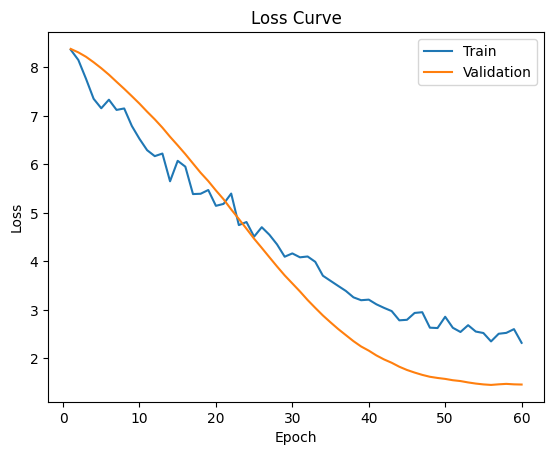

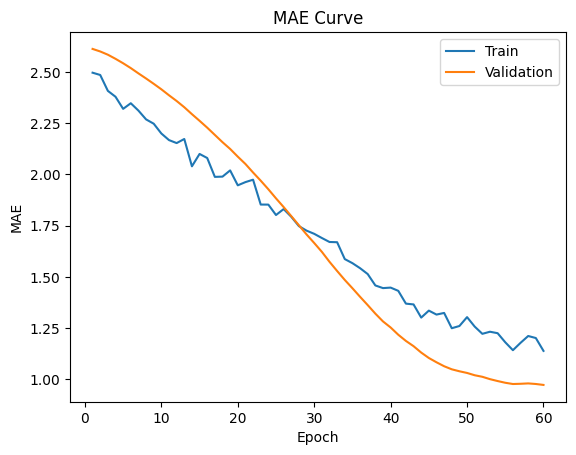

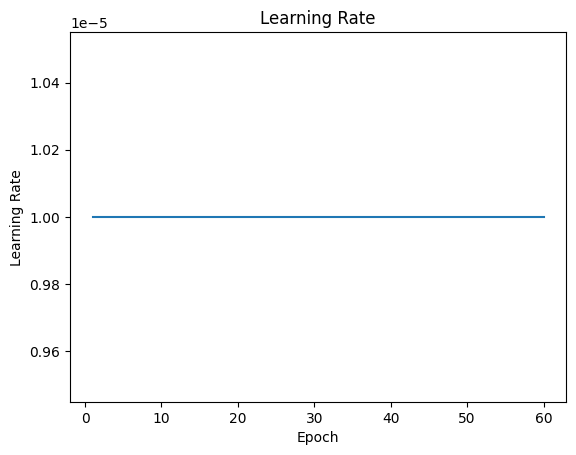

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [25]:
import os
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback

DATA_ROOT = "/content/csiro-biomass"
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 60
AUTOTUNE = tf.data.AUTOTUNE

TARGET_COLS = [
    "Dry_Clover_g",
    "Dry_Dead_g",
    "Dry_Green_g",
    "Dry_Total_g",
    "GDM_g"
]

train_df = pd.read_csv(f"{DATA_ROOT}/train.csv")

pivot_df = train_df.pivot_table(
    index="image_path",
    columns="target_name",
    values="target",
    aggfunc="mean"
).reset_index()

num_df = (
    train_df
    .groupby("image_path")[["Pre_GSHH_NDVI", "Height_Ave_cm"]]
    .mean()
    .reset_index()
)

pivot_df = pivot_df.merge(num_df, on="image_path").dropna()

X_img = (DATA_ROOT + "/" + pivot_df["image_path"]).values
X_num = pivot_df[["Pre_GSHH_NDVI", "Height_Ave_cm"]].values
y = np.log1p(pivot_df[TARGET_COLS].values)

Ximg_tr, Ximg_val, Xnum_tr, Xnum_val, y_tr, y_val = train_test_split(
    X_img, X_num, y, test_size=0.2, random_state=42
)

def load_train(img_path, num_feats, label):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, 0.1)
    img = tf.image.random_contrast(img, 0.9, 1.1)
    img = tf.cast(img, tf.float32) / 255.0
    return {"image": img, "numeric": num_feats}, label

def load_val(img_path, num_feats, label):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return {"image": img, "numeric": num_feats}, label

train_ds = tf.data.Dataset.from_tensor_slices((Ximg_tr, Xnum_tr, y_tr))
train_ds = train_ds.map(load_train, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.shuffle(1024).batch(BATCH_SIZE).repeat().prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((Ximg_val, Xnum_val, y_val))
val_ds = val_ds.map(load_val, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

img_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="image")

cnn = EfficientNetB0(
    include_top=False,
    weights=None,
    input_tensor=img_input
)

cnn.trainable = True

x_img = GlobalAveragePooling2D()(cnn.output)
x_img = Dense(256, activation="relu")(x_img)
x_img = Dropout(0.4)(x_img)

num_input = Input(shape=(2,), name="numeric")
x_num = Dense(64, activation="relu")(num_input)
x_num = Dense(32, activation="relu")(x_num)
x_num = Dense(16, activation="relu")(x_num)

x = Concatenate()([x_img, x_num])
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)

outputs = Dense(5, activation="linear")(x)

model = Model(inputs=[img_input, num_input], outputs=outputs)

def biomass_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    constraint = tf.reduce_mean(
        tf.square(y_pred[:, 3] - (y_pred[:, 0] + y_pred[:, 1] + y_pred[:, 2]))
    )
    return mse + 0.5 * constraint

optimizer = Adam(1e-5)

model.compile(
    optimizer=optimizer,
    loss=biomass_loss,
    metrics=["mae"]
)

class LRLogger(Callback):
    def on_train_begin(self, logs=None):
        self.lrs = []
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate
        self.lrs.append(float(tf.keras.backend.get_value(lr)))

steps_per_epoch = len(Ximg_tr) // BATCH_SIZE
val_steps = len(Ximg_val) // BATCH_SIZE

lr_logger = LRLogger()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    steps_per_epoch=steps_per_epoch,
    validation_steps=val_steps,
    epochs=EPOCHS,
    callbacks=[lr_logger]
)

epochs_range = range(1, EPOCHS + 1)

plt.figure()
plt.plot(epochs_range, history.history["loss"])
plt.plot(epochs_range, history.history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])
plt.title("Loss Curve")
plt.show()

plt.figure()
plt.plot(epochs_range, history.history["mae"])
plt.plot(epochs_range, history.history["val_mae"])
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend(["Train", "Validation"])
plt.title("MAE Curve")
plt.show()

plt.figure()
plt.plot(epochs_range, lr_logger.lrs)
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate")
plt.show()

test_df = pd.read_csv(f"{DATA_ROOT}/test.csv")
test_df = test_df.drop_duplicates(subset="image_path").reset_index(drop=True)

X_test_img = (DATA_ROOT + "/" + test_df["image_path"]).values
num_means = pivot_df[["Pre_GSHH_NDVI", "Height_Ave_cm"]].mean().values
X_test_num = np.tile(num_means, (len(test_df), 1))

def load_test(img_path, num_feats):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return {"image": img, "numeric": num_feats}

test_ds = tf.data.Dataset.from_tensor_slices((X_test_img, X_test_num))
test_ds = test_ds.map(load_test, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

test_preds = model.predict(test_ds)
test_preds = np.expm1(test_preds)
test_preds = np.maximum(test_preds, 0)
test_preds[:, 3] = test_preds[:, 0] + test_preds[:, 1] + test_preds[:, 2]

rows = []
for img_path, p in zip(X_test_img, test_preds):
    image_id = os.path.basename(img_path).replace(".jpg", "")
    for name, val in zip(TARGET_COLS, p):
        rows.append([f"{image_id}__{name}", float(val)])

submission = pd.DataFrame(rows, columns=["sample_id", "target"])

In [26]:
submission.to_csv("submission.csv", index=False)
print("submission.csv saved")

submission.csv saved
